In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [18]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [19]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [20]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [26]:
# Data exploration & validation for Measurement

first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f9f83cc3908>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1}

In [27]:
# Data exploration & validation for Stations

first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f9f83cc3ac8>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [31]:
# Find the most recent date in the data set.

mostrecent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(mostrecent)

('2017-08-23',)


In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

latestdate = dt.datetime.strptime(mostrecent[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

selection = [Measurement.date,Measurement.prcp]
queryanswer = session.query(*selection).filter(Measurement.date >= querydate).all()

precipitation = pd.DataFrame(queryanswer, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any')
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation.head()




,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


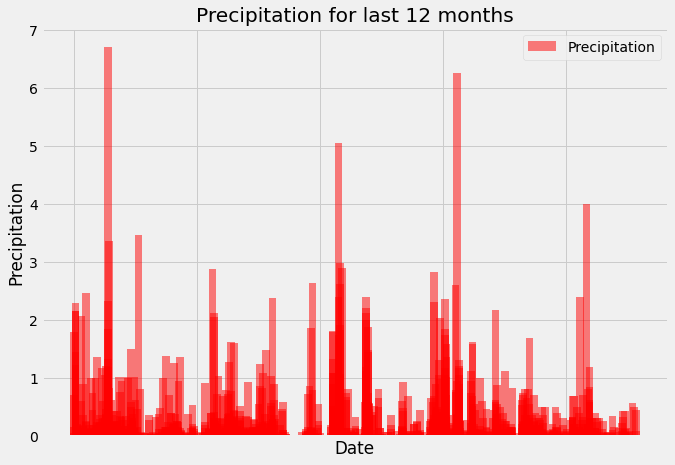

In [41]:
# Use Pandas Plotting with Matplotlib to plot the data

xaxisvalues = precipitation.index.tolist()
yaxisvalues = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xaxisvalues,yaxisvalues,width = 5 ,color='r', alpha=0.5, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation for last 12 months")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number stations in the dataset

session.query(Station.id).count()

9

In [46]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

totalmeasurements = [Measurement.station,func.count(Measurement.id)]

activestations = session.query(*totalmeasurements).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [51]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

mostactivestation = 'USC00519281'
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == mostactivestation).all()


[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:ylabel='Frequency'>

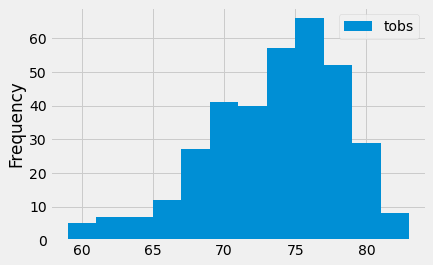

In [58]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

mostactivestation = 'USC00519281'

results = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.date >= "2016-08-24").\
                        filter(Measurement.date <= "2017-08-23").\
                        filter(Measurement.station == mostactivestation).all()

results_df = pd.DataFrame(results)

results_df.plot.hist(bins=12)

# Close session

In [59]:
# Close Session
session.close()